## Explore sample intersection between TCGA data types

As we add more data types to our classification experiments, we've been filtering to only the set of samples that have data for each included data type. We want to know more about how many samples and which/how many cancer types are affected by this filtering, since it could influence the results in subtle ways.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg

In [2]:
# get sample list for each data type
sample_lists = {}
for training_data, sample_info_file in cfg.sample_infos.items():
    samples = pd.read_csv(sample_info_file, sep='\t', index_col=0).index
    sample_lists[training_data] = set(samples)

In [3]:
# counts per data type
print('\n'.join(['{}\t{}'.format(n, len(v)) for n, v in sample_lists.items()]))

We'll start by just counting the number of samples that have data for each of the relevant data types.

Text(0.5, 1.0, 'Sample overlap between TCGA data types')

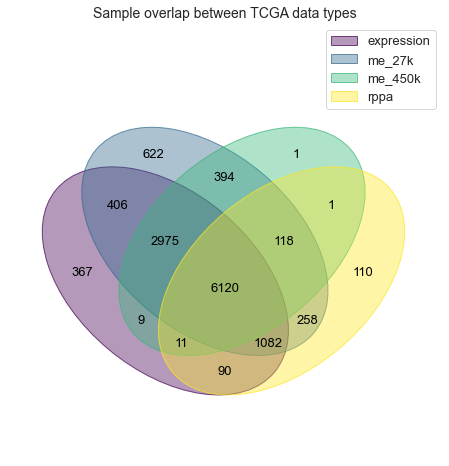

In [4]:
# do venn diagram
from venn import venn
sns.set_style('white')
venn(sample_lists)
plt.title('Sample overlap between TCGA data types', size=14)

In [5]:
# add mutation data to sample list
import mpmp.utilities.data_utilities as du

pancan_data = du.load_pancancer_data()
(sample_freeze_df,
 mutation_df,
 copy_loss_df,
 copy_gain_df,
 mut_burden_df) = pancan_data

print(sample_freeze_df.shape)
print(mutation_df.shape)
print(copy_loss_df.shape)
print(copy_gain_df.shape)
print(mut_burden_df.shape)

(9074, 4)
(9074, 20938)
(9074, 25128)
(9074, 25128)
(9074, 1)


In [6]:
# these all contain the same samples, so just use one of the indexes
sample_lists['mutation'] = set(mutation_df.index)

Text(0.5, 1.0, 'Sample overlap between TCGA data types')

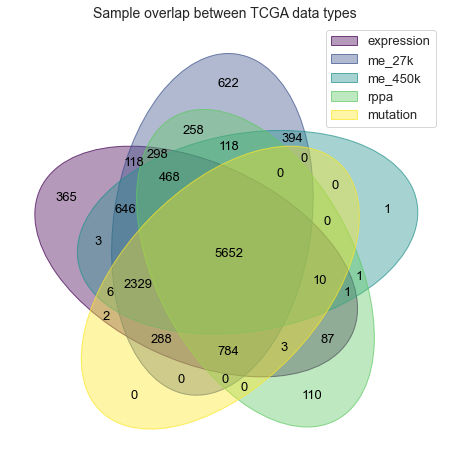

In [7]:
# venn diagram including mutation info
from venn import venn
sns.set_style('white')
venn(sample_lists)
plt.title('Sample overlap between TCGA data types', size=14)

### Cancer type analysis

The sample counts by themselves aren't that informative. More specifically, we want to know which cancer types are getting dropped when we take the overlap between data types. That is, are there certain cancer types that are or are not generally in the overlap, or are the samples we filter out roughly uniformly distributed between cancer types?

In [8]:
# get sample info (sample IDs and cancer types) for each data modality

# there are no samples for which we have mutation data and not other data types,
# so we only need these four

sample_info_dfs = {}
for data_type in cfg.sample_infos.keys():
    sample_info_dfs[data_type] = pd.read_csv(cfg.sample_infos[data_type], 
                                             sep='\t', index_col=0)
print(
    sample_info_dfs['expression'].shape,
    sample_info_dfs['me_27k'].shape,
    sample_info_dfs['me_450k'].shape,
    sample_info_dfs['rppa'].shape
)
sample_info_dfs['expression'].head()

(11060, 3) (11975, 3) (9629, 3) (7790, 3)


,sample_type,cancer_type,id_for_stratification
sample_id,,,
TCGA-02-0047-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-0055-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2483-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2485-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor
TCGA-02-2486-01,Primary Solid Tumor,GBM,GBMPrimary Solid Tumor


In [9]:
# the goal here is to examine how the proportion of cancer types changes when we add
# new data modalities

# here, we specify these manually since the order matters
# (i.e. order in data_types => order in which new data is "added")
data_types = ['expression', 'me_27k', 'me_450k', 'rppa']

exp_cancer_types = (sample_info_dfs['expression']
    .groupby('cancer_type')
    .size()
    .sort_values(ascending=False)
)

mutation_samples = sample_lists['mutation']
exp_mut_cancer_types = (sample_info_dfs['expression']
    .loc[mutation_samples]
    .groupby('cancer_type')
    .size()
    .sort_values(ascending=False)
)
diff_df = exp_cancer_types - exp_mut_cancer_types

In [10]:
# check these are all in expression data (they should be)
cur_samples = set(mutation_samples)
diff_df = pd.DataFrame(diff_df, columns=['mutation'])
cur_counts = exp_mut_cancer_types

for ix, data_type in enumerate(data_types[1:], 1):
    cur_samples = cur_samples.intersection(
        sample_lists[data_type]
    )
    print(data_type, len(cur_samples))
    overlap_counts = (sample_info_dfs[data_type]
        .loc[cur_samples]
        .groupby('cancer_type')
        .size()
        .reindex(cur_counts.index)
        .fillna(0)
        .sort_values(ascending=False)
    )
    diff = (cur_counts - overlap_counts).astype(int)
    cur_counts = overlap_counts
    df = pd.DataFrame(diff, columns=[data_type])
    diff_df = pd.concat((diff_df, df), axis=1)
    
diff_df = pd.concat((diff_df, 
                     pd.DataFrame(
                         overlap_counts,
                         columns=['rppa_base']
                    )), axis=1).fillna(0).astype(int)
print(diff_df.shape)
diff_df.head(33)

me_27k 9053
me_450k 7981
rppa 5652
(33, 5)


,mutation,me_27k,me_450k,rppa,rppa_base
ACC,3,0,0,32,44
BLCA,29,0,0,68,330
BRCA,237,16,291,117,557
CESC,38,0,0,124,148
CHOL,9,0,3,6,27
COAD,154,0,77,38,226
DLBC,11,0,0,10,27
ESCA,27,0,0,53,116
GBM,48,0,73,18,33
HNSC,79,0,0,285,202


In [11]:
compare_df = pd.concat((
    pd.DataFrame(
        sample_info_dfs['expression'].groupby('cancer_type').size().fillna(0),
        columns=['expression']
    ), 
    pd.DataFrame(
        diff_df.sum(axis=1),
        columns=['other']
    )
), axis=1)
assert (compare_df.expression.values == compare_df.other.values).all()

Text(0, 0.5, 'Sample count')

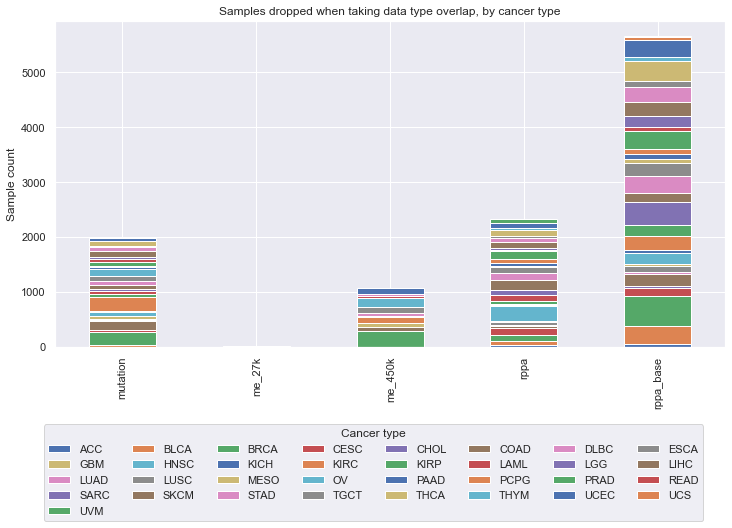

In [12]:
def flip(items, ncol):
    # fill in legend by rows instead of columns
    # https://stackoverflow.com/a/10101532
    import itertools as it
    return it.chain(*[items[i::ncol] for i in range(ncol)])

sns.set()
diff_df.T.plot.bar(stacked=True, figsize=(12, 6))
h, l = plt.gca().get_legend_handles_labels()
plt.legend(flip(h, 8), flip(l, 8), bbox_to_anchor=(-0.025, -0.55),
           loc='lower left', ncol=8, title='Cancer type')
plt.title('Samples dropped when taking data type overlap, by cancer type')
plt.ylabel('Sample count')

In [13]:
# instead of plotting absolute number of each cancer type dropped at
# each step, plot the proportion of each cancer type (i.e. count divided
# by total sample count for that cancer type)
diff_norm_df = diff_df / np.tile(diff_df.sum(axis=1).values, (diff_df.shape[1], 1)).T
diff_norm_df.head()

,mutation,me_27k,me_450k,rppa,rppa_base
ACC,0.037975,0.000000,0.000000,0.405063,0.556962
BLCA,0.067916,0.000000,0.000000,0.159251,0.772834
BRCA,0.194581,0.013136,0.238916,0.096059,0.457307
CESC,0.122581,0.000000,0.000000,0.400000,0.477419
CHOL,0.200000,0.000000,0.066667,0.133333,0.600000


Text(0, 0.5, 'Proportion')

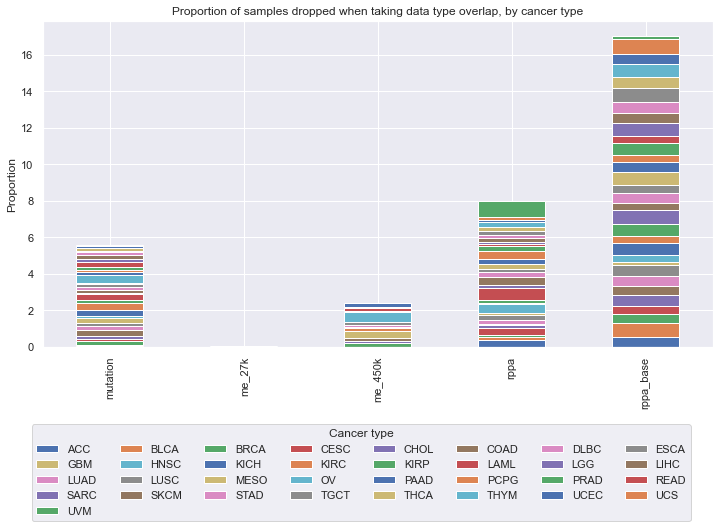

In [14]:
sns.set()
diff_norm_df.T.plot.bar(stacked=True, figsize=(12, 6))
h, l = plt.gca().get_legend_handles_labels()
plt.legend(flip(h, 8), flip(l, 8), bbox_to_anchor=(-0.025, -0.55),
           loc='lower left', ncol=8, title='Cancer type')
plt.title('Proportion of samples dropped when taking data type overlap, by cancer type')
plt.ylabel('Proportion')